In [1]:
from sklearn.feature_extraction.text import CountVectorizer
import torch
import pandas as pd
from xml.dom import minidom

#Function to parse endnote xml file
def parseXML(filename, isInclude):
    abstracts = []
    tags = []
    xmldoc = minidom.parse(filename)
    for node in xmldoc.getElementsByTagName('abstract'):
        abstract = node.getElementsByTagName('style')[0].firstChild.nodeValue
        abstracts.append(abstract)
        tags.append(isInclude)
    return abstracts, tags

def calculate_embeddings_bow(abstracts):
    countVectorizer = CountVectorizer(stop_words="english", max_features=768)
    embeddings = countVectorizer.fit_transform(abstracts).todense().tolist()
    return embeddings

# MAIN function used to load xml and return embeddingsP
def get_dataframe_with_embeddings(dataset_name):
    # Initialize cuda
    print("Is CUDA avaliable:", torch.cuda.is_available())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Device:", device)

    # Parse XML and build dataset
    abstractsInclude, tagsInclude = parseXML("datasets/" + dataset_name + '/' + dataset_name + 'Include.xml', 1)
    abstractsExclude, tagsExclude = parseXML("datasets/" + dataset_name + '/' + dataset_name + 'Exclude.xml', 0)
    df = pd.DataFrame(list(zip(tagsInclude + tagsExclude, abstractsInclude + abstractsExclude)), columns =['code', 'abstract'])

    # Get embeddings
    df['embedding'] = calculate_embeddings_bow(df['abstract'])

    # Return dataframe
    return df

In [2]:
# Imports
import sys

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import numpy as np

from IPython.display import clear_output
from math import ceil

# Count number of included articles
def countIncludes(df):
    return len(df[df.code == 1].index)

# Create training and testing set
# Use 20% of included articles and equal number of excludes
def createTrainTest(df, train_proportion=0.2):
    # Split include and exclude data
    includes = df[df.code == 1]
    excludes = df[df.code == 0]
    # Take 20% of the total includes
    train_size = ceil(len(includes) * train_proportion)
    # Get training data
    train_includes = includes.sample(train_size)
    train_excludes = excludes.sample(train_size)
    # Remove training data from testing data
    includes.drop(train_includes.index)
    excludes.drop(train_excludes.index)
    # Return train and test
    return pd.concat([train_includes, train_excludes]), pd.concat([includes, excludes])

# Function to calculate probabilities of each remaining article
def calcProb(model, initial, remaining):
    # Get initial training data and labels
    initial_data = initial['embedding'].tolist()
    initial_labels = initial['code'].tolist()

    # Fit model to initial training data
    model.fit(initial_data, initial_labels)

    # Get remaining data for testing
    remaining_data = remaining['embedding'].tolist()

    # Predict probability [exclusion, inclusion] on remaining articles
    pred = model.predict_proba(remaining_data)

    # Calculate score (x[1] = probability of inclusion)
    pred = list(map(lambda x: x[1], pred))
    # Add probability to dataframe
    remaining['prob'] = pred
    # Sort by probability
    remaining = remaining.sort_values(by=['prob'], ascending=False).reset_index(drop=True)

    return remaining

# Simulate screening process and return effort and accuracy metrics
def simulateScreening(df, randomOrder = False):
    # Intialize metrics
    effort_list = []
    accuracy_list = []
    # Create training/testing data
    labelled, unlabelled = createTrainTest(df)

    # Shuffle data
    labelled = labelled.sample(frac=1).reset_index(drop=True)
    unlabelled = unlabelled.sample(frac=1).reset_index(drop=True)

    # Load model
    # model = LogisticRegression(C=0.05, class_weight='balanced', max_iter=1000)
    # model = SVC(probability=True)
    model = MLPClassifier()

    # Find total number of includes
    total_includes = countIncludes(df)

    while(unlabelled.index[-1] > 0):
        # Calculate number of included articles found so far
        includes_found = countIncludes(labelled)

        # Calculate the effort of the model so far
        effort = len(labelled) / len(df)
        # Calculate the accuracy of the model at this point
        accuracy = includes_found/total_includes
        # Append stats to lists
        effort_list.append(effort)
        accuracy_list.append(accuracy)

        # Early termination
        if(includes_found == total_includes):
            # Have found all articles
            break

        # Calculate and sort unlabelled data (to get documents rankings)
        if not randomOrder:
            unlabelled = calcProb(model, labelled, unlabelled)

        # Take highest ranking remaining article and add it to labelled data
        # Drop it from unlabbeled data
        # (This simuates querying/screening the highest ranked document)
        labelled = pd.concat([labelled, unlabelled.iloc[[0]]], ignore_index=True)
        unlabelled.drop(0, inplace=True)
        unlabelled.reset_index(drop=True, inplace=True)

    # Return effort and accuracy data for screening simulation
    return effort_list, accuracy_list

# Take the average of multiple hidden layers
def average_layers(layers):
    data = np.array(layers)
    return np.average(data, axis=0)

Is CUDA avaliable: False
Device: cpu


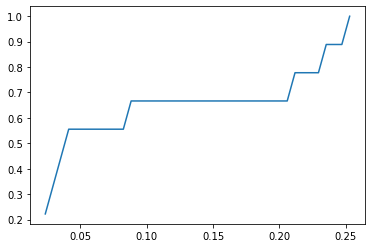

In [3]:
import matplotlib.pyplot as plt

name = "bacteriuria"
df = get_dataframe_with_embeddings(name)
df.head()
stats = simulateScreening(df)
plt.plot(stats[0], stats[1])
plt.show()